In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# 1.Import the libraries

In [3]:
!pip install tqdm
from tqdm import tqdm

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.cuda.amp import autocast
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torchvision.transforms import RandAugment

import random
import PIL
import os
import albumentations as A
from PIL import Image
import timm

# 2.Data Loading

In [26]:
class AlbumentationsTransform:
    def __init__(self):
        self.transform = A.Compose([
            A.ElasticTransform(p=random.uniform(0.2, 0.5), alpha=random.randint(20, 40), sigma=random.uniform(4, 6)),
            A.CLAHE(p=0.5),
            A.GridDistortion(p=random.uniform(0.2, 0.5)),
            A.HorizontalFlip(p=0.5),
            A.RandomBrightnessContrast(p=0.3)
        ])

    def __call__(self, img):
        img = np.array(img)
        augmented = self.transform(image=img)
        return Image.fromarray(augmented['image'])

train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    AlbumentationsTransform(),
    RandAugment(num_ops=3, magnitude=10),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

])

train_dataset = datasets.ImageFolder(root="/content/drive/MyDrive/data_HAM/train", transform=train_transform)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=4, pin_memory=True)

images, labels = next(iter(train_loader))
print(images.shape, labels.shape)

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


torch.Size([64, 3, 224, 224]) torch.Size([64])


In [27]:
val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    RandAugment(num_ops=2, magnitude=9),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_dataset = datasets.ImageFolder(root="/content/drive/MyDrive/data_HAM/val", transform=val_transform)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False, num_workers=4, pin_memory=True)

images, labels = next(iter(val_loader))
print(images.shape, labels.shape)

torch.Size([64, 3, 224, 224]) torch.Size([64])


# 3. Model implementation

In [28]:
class CNNViT(nn.Module):
    def __init__(self, num_classes=7):
        super(CNNViT, self).__init__()

        self.cnn = timm.create_model('resnet34', pretrained=True, features_only=True)

        self.fusion = nn.Sequential(
            nn.Conv2d(512, 256, 3, padding=1),
            nn.BatchNorm2d(256),
            nn.GELU(),
            nn.Dropout(0.5),
            nn.Conv2d(256, 3, 3, padding=1)
        )

        self.vit = timm.create_model('vit_base_patch16_224', pretrained=True)

        self.classifier = nn.Sequential(
            nn.Linear(512 + 768, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        cnn_features = self.cnn(x)[-1]  # Last layer output [B, 512, 7, 7]

        # Global average pooling (turn into [B, 512])
        cnn_global_features = F.adaptive_avg_pool2d(cnn_features, (1, 1)).view(x.size(0), -1)

        # CNN→RGB projection (for ViT input)
        projected = self.fusion(cnn_features)

        # Upsample to 224x224 for ViT input
        upsampled = F.interpolate(projected, size=(224, 224), mode='bilinear', align_corners=False)

        vit_features = self.vit.forward_features(upsampled)
        vit_cls_token = vit_features[:, 0]  # CLS token only [B, 768]

        combined_features = torch.cat([cnn_global_features, vit_cls_token], dim=1)
        logits = self.classifier(combined_features)
        return logits

In [29]:
class LabelSmoothingLoss(nn.Module):
    def __init__(self, classes, smoothing=0.1, dim=-1):
        super(LabelSmoothingLoss, self).__init__()
        self.confidence = 1.0 - smoothing
        self.smoothing = smoothing
        self.cls = classes
        self.dim = dim

    def forward(self, pred, target):
        pred = pred.log_softmax(dim=self.dim)
        with torch.no_grad():
            true_dist = torch.zeros_like(pred)
            true_dist.fill_(self.smoothing / (self.cls - 1))
            true_dist.scatter_(1, target.data.unsqueeze(1), self.confidence)
        return torch.mean(torch.sum(-true_dist * pred, dim=self.dim))

In [30]:
model = CNNViT(num_classes=7)

criterion = LabelSmoothingLoss(classes=7, smoothing=0.1)
optimizer = torch.optim.AdamW(model.parameters(), lr=3e-4, weight_decay=5e-3)

model = nn.DataParallel(model) #imp
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

DataParallel(
  (module): CNNViT(
    (cnn): FeatureListNet(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (act1): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (drop_block): Identity()
          (act1): ReLU(inplace=True)
          (aa): Identity()
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (act2): ReLU(inplace=True)
        )
        (1): BasicBlock(
          (conv1)

# 4. Training Process

In [10]:
def save_checkpoint(model, optimizer, epoch, path):
    os.makedirs(os.path.dirname(path), exist_ok=True)

    checkpoint = {
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict()
    }
    torch.save(checkpoint, path)
    print(f"Checkpoint saved to {path}")


In [11]:
class EarlyStopping:
    def __init__(self, patience=3, verbose=False, delta=0, path='checkpoint.pt', trace_func=print):
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta
        self.path = path
        self.trace_func = trace_func
    def __call__(self, val_loss, model, optimizer):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model, optimizer)
        elif score < self.best_score + self.delta:
            self.counter += 1
            self.trace_func(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model, optimizer)
            self.counter = 0

    def save_checkpoint(self, val_loss, model, optimizer):
        if self.verbose:
            self.trace_func(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        if val_loss < self.val_loss_min:
            torch.save({
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict()
                }, self.path)
            self.val_loss_min = val_loss

In [31]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
scaler = torch.cuda.amp.GradScaler()

num_epochs = 25
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []
true_labels = []
predicted_labels = []
early_stopping = EarlyStopping(patience=3, verbose=True, path='/content/drive/MyDrive/checkpoints/checkpoint_early_stopping.pt')


for epoch in range(num_epochs):
    # === Training ===
    model.train()
    train_loss, correct, total = 0, 0, 0

    for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Training"):
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        with autocast():
            output = model(images)
            loss = criterion(output, labels)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        train_loss += loss.item() * images.size(0)
        _, predicted = output.max(1)
        total += labels.size(0)

        if 'labels_a' in locals():
            correct += (lam * predicted.eq(labels_a).sum().item() + (1 - lam) * predicted.eq(labels_b).sum().item())
        else:
            correct += predicted.eq(labels).sum().item()

    train_acc = 100. * correct / total
    train_loss /= total

    # === Validation ===
    model.eval()
    val_loss, correct, total = 0, 0, 0

    with torch.no_grad():
        for images, labels in tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Validation"):
            images, labels = images.to(device), labels.to(device)
            with autocast():
                output = model(images)
                loss = criterion(output, labels)

            val_loss += loss.item() * images.size(0)
            _, predicted = output.max(1)
            true_labels.extend(labels.cpu().numpy())
            predicted_labels.extend(predicted.cpu().numpy())
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    val_acc = 100. * correct / total
    val_loss /= total

    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)

    early_stopping(val_loss, model, optimizer)
    if early_stopping.early_stop:
        print("Early stopping")
        break

    if (epoch + 1) % 5 == 0:
        checkpoint_path = os.path.join('/content/drive/MyDrive/checkpoints', f'epoch_{epoch + 1}.pth')
        save_checkpoint(model, optimizer, epoch + 1, checkpoint_path)

    print(f"Epoch {epoch+1}/{num_epochs}: Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%")
    print(f"                    Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%\n")

<ipython-input-31-e1aa243f96cf>:3: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()
Epoch 1/25 - Training:   0%|          | 0/126 [00:00<?, ?it/s]<ipython-input-31-e1aa243f96cf>:24: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Epoch 1/25 - Validation:   0%|          | 0/32 [00:00<?, ?it/s]<ipython-input-31-e1aa243f96cf>:51: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Epoch 1/25 - Validation: 100%|██████████| 32/32 [00:18<00:00,  1.74it/s]


Validation loss decreased (inf --> 1.526764).  Saving model ...
Epoch 1/25: Train Loss: 1.8281, Train Acc: 24.62%
                    Val Loss: 1.5268, Val Acc: 42.98%



Epoch 2/25 - Validation: 100%|██████████| 32/32 [00:18<00:00,  1.74it/s]


Validation loss decreased (1.526764 --> 1.426986).  Saving model ...
Epoch 2/25: Train Loss: 1.5094, Train Acc: 44.02%
                    Val Loss: 1.4270, Val Acc: 53.64%



Epoch 3/25 - Validation: 100%|██████████| 32/32 [00:17<00:00,  1.83it/s]


Validation loss decreased (1.426986 --> 1.247396).  Saving model ...
Epoch 3/25: Train Loss: 1.3715, Train Acc: 54.14%
                    Val Loss: 1.2474, Val Acc: 61.63%



Epoch 4/25 - Validation: 100%|██████████| 32/32 [00:17<00:00,  1.83it/s]


Validation loss decreased (1.247396 --> 1.160261).  Saving model ...
Epoch 4/25: Train Loss: 1.2674, Train Acc: 60.93%
                    Val Loss: 1.1603, Val Acc: 67.82%



Epoch 5/25 - Validation: 100%|██████████| 32/32 [00:17<00:00,  1.84it/s]


Validation loss decreased (1.160261 --> 1.092891).  Saving model ...
Checkpoint saved to /content/drive/MyDrive/checkpoints/epoch_5.pth
Epoch 5/25: Train Loss: 1.1873, Train Acc: 65.14%
                    Val Loss: 1.0929, Val Acc: 71.34%



Epoch 6/25 - Validation: 100%|██████████| 32/32 [00:17<00:00,  1.84it/s]


Validation loss decreased (1.092891 --> 1.064108).  Saving model ...
Epoch 6/25: Train Loss: 1.1323, Train Acc: 69.07%
                    Val Loss: 1.0641, Val Acc: 71.64%



Epoch 7/25 - Validation: 100%|██████████| 32/32 [00:17<00:00,  1.78it/s]


Validation loss decreased (1.064108 --> 1.000480).  Saving model ...
Epoch 7/25: Train Loss: 1.0790, Train Acc: 71.25%
                    Val Loss: 1.0005, Val Acc: 74.37%



Epoch 8/25 - Validation: 100%|██████████| 32/32 [00:17<00:00,  1.79it/s]


Validation loss decreased (1.000480 --> 0.965180).  Saving model ...
Epoch 8/25: Train Loss: 1.0495, Train Acc: 73.46%
                    Val Loss: 0.9652, Val Acc: 77.74%



Epoch 9/25 - Validation: 100%|██████████| 32/32 [00:17<00:00,  1.80it/s]


Validation loss decreased (0.965180 --> 0.940490).  Saving model ...
Epoch 9/25: Train Loss: 1.0103, Train Acc: 75.27%
                    Val Loss: 0.9405, Val Acc: 77.79%



Epoch 10/25 - Validation: 100%|██████████| 32/32 [00:18<00:00,  1.77it/s]


EarlyStopping counter: 1 out of 3
Checkpoint saved to /content/drive/MyDrive/checkpoints/epoch_10.pth
Epoch 10/25: Train Loss: 0.9818, Train Acc: 76.36%
                    Val Loss: 0.9758, Val Acc: 76.30%



Epoch 11/25 - Validation: 100%|██████████| 32/32 [00:18<00:00,  1.75it/s]


EarlyStopping counter: 2 out of 3
Epoch 11/25: Train Loss: 0.9512, Train Acc: 78.53%
                    Val Loss: 0.9546, Val Acc: 77.59%



Epoch 12/25 - Validation: 100%|██████████| 32/32 [00:17<00:00,  1.79it/s]


Validation loss decreased (0.940490 --> 0.922661).  Saving model ...
Epoch 12/25: Train Loss: 0.9259, Train Acc: 79.30%
                    Val Loss: 0.9227, Val Acc: 78.88%



Epoch 13/25 - Validation: 100%|██████████| 32/32 [00:17<00:00,  1.86it/s]


EarlyStopping counter: 1 out of 3
Epoch 13/25: Train Loss: 0.9141, Train Acc: 80.52%
                    Val Loss: 0.9257, Val Acc: 78.28%



Epoch 14/25 - Validation: 100%|██████████| 32/32 [00:18<00:00,  1.74it/s]


Validation loss decreased (0.922661 --> 0.891877).  Saving model ...
Epoch 14/25: Train Loss: 0.8932, Train Acc: 81.57%
                    Val Loss: 0.8919, Val Acc: 80.66%



Epoch 15/25 - Validation: 100%|██████████| 32/32 [00:17<00:00,  1.80it/s]


EarlyStopping counter: 1 out of 3
Checkpoint saved to /content/drive/MyDrive/checkpoints/epoch_15.pth
Epoch 15/25: Train Loss: 0.8630, Train Acc: 82.69%
                    Val Loss: 0.9045, Val Acc: 79.72%



Epoch 16/25 - Validation: 100%|██████████| 32/32 [00:18<00:00,  1.70it/s]


Validation loss decreased (0.891877 --> 0.848221).  Saving model ...
Epoch 16/25: Train Loss: 0.8498, Train Acc: 83.55%
                    Val Loss: 0.8482, Val Acc: 83.49%



Epoch 17/25 - Validation: 100%|██████████| 32/32 [00:18<00:00,  1.78it/s]


Validation loss decreased (0.848221 --> 0.839421).  Saving model ...
Epoch 17/25: Train Loss: 0.8313, Train Acc: 84.46%
                    Val Loss: 0.8394, Val Acc: 83.29%



Epoch 18/25 - Validation: 100%|██████████| 32/32 [00:17<00:00,  1.79it/s]


EarlyStopping counter: 1 out of 3
Epoch 18/25: Train Loss: 0.8141, Train Acc: 85.54%
                    Val Loss: 0.8616, Val Acc: 82.10%



Epoch 19/25 - Validation: 100%|██████████| 32/32 [00:21<00:00,  1.51it/s]


Validation loss decreased (0.839421 --> 0.835384).  Saving model ...
Epoch 19/25: Train Loss: 0.8052, Train Acc: 85.91%
                    Val Loss: 0.8354, Val Acc: 84.28%



Epoch 20/25 - Validation: 100%|██████████| 32/32 [00:17<00:00,  1.84it/s]


Validation loss decreased (0.835384 --> 0.816038).  Saving model ...
Checkpoint saved to /content/drive/MyDrive/checkpoints/epoch_20.pth
Epoch 20/25: Train Loss: 0.7803, Train Acc: 87.72%
                    Val Loss: 0.8160, Val Acc: 85.13%



Epoch 21/25 - Validation: 100%|██████████| 32/32 [00:17<00:00,  1.82it/s]


EarlyStopping counter: 1 out of 3
Epoch 21/25: Train Loss: 0.7678, Train Acc: 87.93%
                    Val Loss: 0.8805, Val Acc: 82.20%



Epoch 22/25 - Validation: 100%|██████████| 32/32 [00:18<00:00,  1.77it/s]


EarlyStopping counter: 2 out of 3
Epoch 22/25: Train Loss: 0.7753, Train Acc: 87.88%
                    Val Loss: 0.8275, Val Acc: 85.18%



Epoch 23/25 - Validation: 100%|██████████| 32/32 [00:17<00:00,  1.82it/s]


Validation loss decreased (0.816038 --> 0.810038).  Saving model ...
Epoch 23/25: Train Loss: 0.7590, Train Acc: 88.55%
                    Val Loss: 0.8100, Val Acc: 85.47%



Epoch 24/25 - Validation: 100%|██████████| 32/32 [00:17<00:00,  1.78it/s]


Validation loss decreased (0.810038 --> 0.789321).  Saving model ...
Epoch 24/25: Train Loss: 0.7488, Train Acc: 88.90%
                    Val Loss: 0.7893, Val Acc: 85.72%



Epoch 25/25 - Validation: 100%|██████████| 32/32 [00:18<00:00,  1.74it/s]


EarlyStopping counter: 1 out of 3
Checkpoint saved to /content/drive/MyDrive/checkpoints/epoch_25.pth
Epoch 25/25: Train Loss: 0.7349, Train Acc: 89.63%
                    Val Loss: 0.8168, Val Acc: 86.12%



# 5. Prediction

In [32]:
class_names=['Melanoma','Melanocytic nevus','Basal cell carcinoma','Actinic keratosis','Benign keratosis','Dermatofibroma','Vascular lesion']

In [33]:
from PIL import Image

In [34]:
image_path = "/content/drive/MyDrive/data_HAM/val/class5/ISIC_0024951.jpg"

image = Image.open(image_path).convert("RGB")

image_tensor = val_transform(image).unsqueeze(0)
image_tensor = image_tensor.to(device)


model.eval()
with torch.no_grad():
    outputs = model(image_tensor)

    predicted_class_index = outputs.argmax(-1).item()

predicted_class_name = class_names[predicted_class_index]
print(f"Predicted class: {predicted_class_name}")

Predicted class: Benign keratosis


# 6. Metrics

In [35]:
print(f"Final Train Loss: {train_losses[-1]:.4f}")
print(f"Final Train Accuracy: {train_accuracies[-1]:.2f}%")

Final Train Loss: 0.7349
Final Train Accuracy: 89.63%


In [36]:
print(f"Final Test Loss: {val_losses[-1]:.4f}")
print(f"Final Test Accuracy: {val_accuracies[-1]:.2f}%")

Final Test Loss: 0.8168
Final Test Accuracy: 86.12%


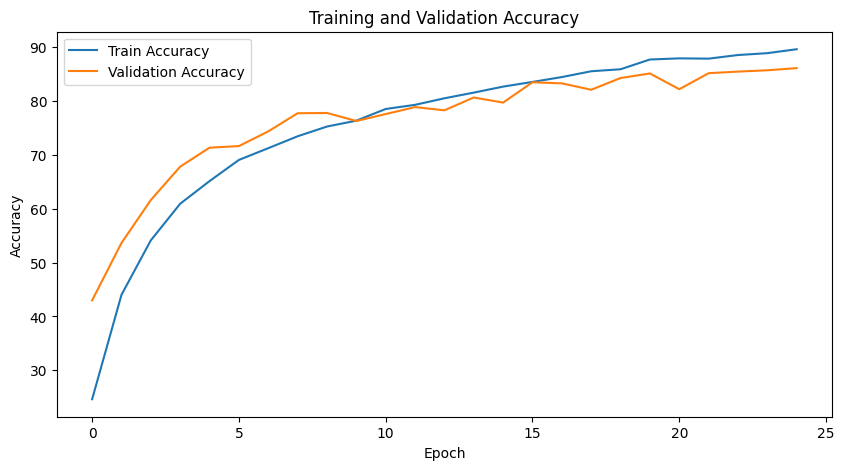

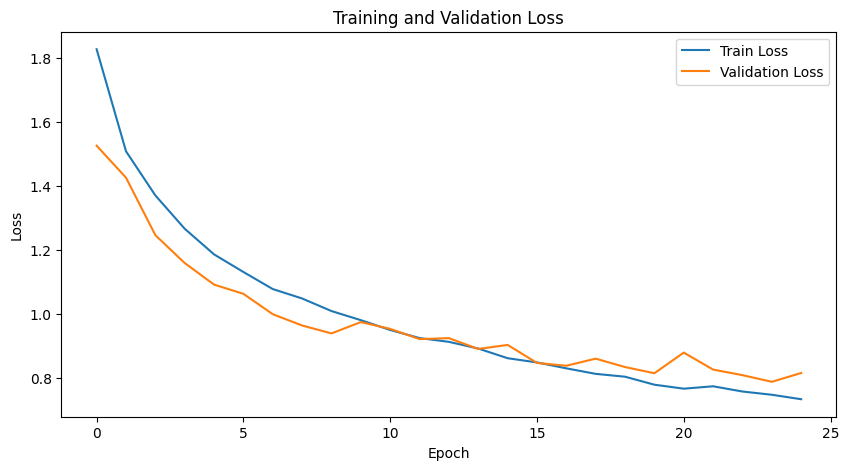

In [37]:
plt.figure(figsize=(10, 5))
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

In [38]:
model = CNNViT(num_classes=7)

checkpoint_path = '/content/drive/MyDrive/checkpoints/checkpoint_early_stopping.pt'
checkpoint = torch.load(checkpoint_path)

from collections import OrderedDict
new_state_dict = OrderedDict()
for k, v in checkpoint['model_state_dict'].items():
    name = k[7:]
    new_state_dict[name] = v

model.load_state_dict(new_state_dict)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.eval()

<ipython-input-38-b543d5639370>:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path)


CNNViT(
  (cnn): FeatureListNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (act1): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (drop_block): Identity()
        (act1): ReLU(inplace=True)
        (aa): Identity()
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (act2): ReLU(inplace=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1

In [39]:
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score
from sklearn.metrics import confusion_matrix

In [40]:
precision = precision_score(true_labels, predicted_labels, average='weighted')
recall = recall_score(true_labels, predicted_labels, average='weighted')
f1 = f1_score(true_labels, predicted_labels, average='weighted')

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1:.4f}")

Precision: 0.7655
Recall: 0.7654
F1-score: 0.7632


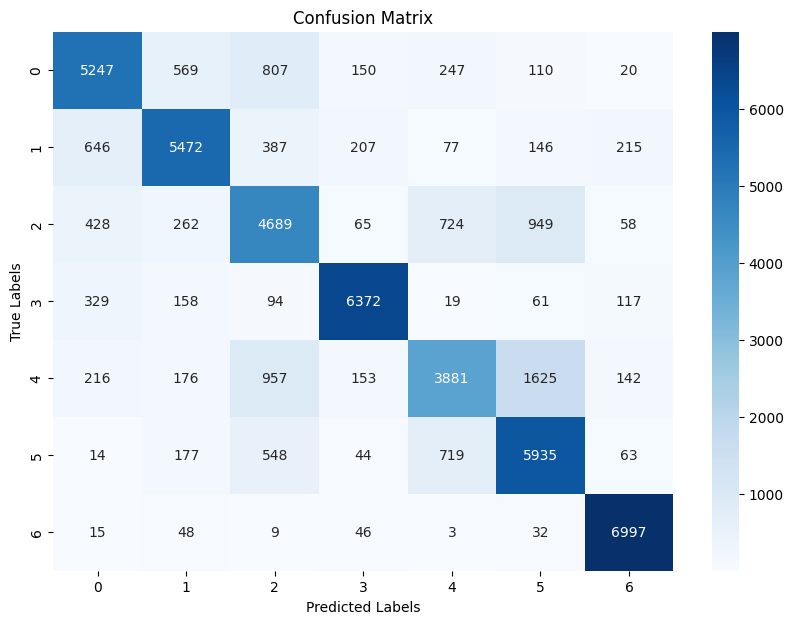

In [41]:
import seaborn as sns
cm = confusion_matrix(true_labels, predicted_labels)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

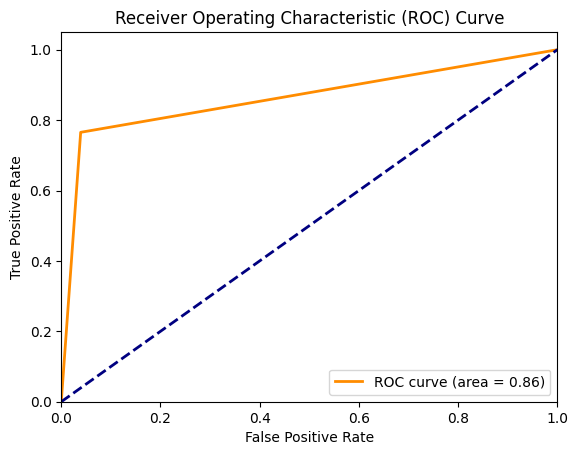

In [42]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

y_true_bin = label_binarize(true_labels, classes=np.unique(true_labels))
y_pred_bin = label_binarize(predicted_labels, classes=np.unique(true_labels))

fpr, tpr, _ = roc_curve(y_true_bin.ravel(), y_pred_bin.ravel())
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()